In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.patches import ConnectionPatch
import statsmodels.formula.api as smf
from statsmodels.nonparametric.kernel_density import KDEMultivariate
from scipy.spatial import distance

import rpy2
print(rpy2.__version__)

import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')
mn = importr('metansue')


from rpy2.robjects import numpy2ri
numpy2ri.activate()

grdevices = importr('grDevices')
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
%matplotlib inline

3.1.0


/Users/nielsond/miniconda3/envs/ge2/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
data_path = Path('../great_expectations_data/data')
output_path = Path('../great_expectations_data/cleaned_data')
output_path.mkdir(exist_ok=True)
figure_path = Path('../great_expectations_figures/')
figure_path.mkdir(exist_ok=True)

In [3]:
def re_meta(ns, rs):
    Ts = np.arctanh(rs)
    vs = 1 / (ns-3)
    ws = 1 / vs
    Q = np.sum(ws * (Ts**2)) - ((np.sum(ws*Ts)**2)/np.sum(ws))
    df = len(ns) - 1
    C = np.sum(ws) - np.sum(ws**2)/np.sum(ws)
    if Q > df:
        tau_squared = (Q - df) / C
    else:
        tau_squared = 0
        
    v_stars = vs + tau_squared
    w_stars = 1/v_stars
    T_sb = np.sum(w_stars*Ts)/np.sum(w_stars)
    se_T = np.sqrt(1 / np.sum(w_stars))
    return T_sb, se_T, tau_squared

In [4]:
robjects.r('mnin <- NULL')
robjects.r('meta_res <- NULL')
robjects.r("""makeinput <- function(r, n, labels){
              mnin = zcor_from_r(r, n, alpha = 0.05, labels = labels)
              print(mnin)
              assign("mnin", mnin, envir = .GlobalEnv)
              mnin
              }""")
makeinput = robjects.globalenv["makeinput"]

robjects.r("""runmeta <- function(mnin){
meta_res = meta(mnin, n.imp=1000)
assign("meta_res", mnin, envir = .GlobalEnv)
print(meta_res)
meta_res
}""")
runmeta = robjects.globalenv["runmeta"]

robjects.r("""runloo <- function(mnin){
loo_res = leave1out(mnin, n.imp=1000)
loo_res
}""")
runloo = robjects.globalenv["runloo"]

robjects.r("""runmb <- function(meta_res){
mb_res = metabias(meta_res)
mb_res
}""")
runmb = robjects.globalenv["runmb"]

robjects.r("""printforest <- function(meta_res){
forest(meta_res)
}
""")
print_forest = robjects.globalenv["printforest"]


robjects.r("""printfunnel <- function(meta_res){
funnel(meta_res)
}
""")
print_funnel = robjects.globalenv["printfunnel"]

robjects.r("""printfunnel <- function(meta_res){
funnel(meta_res)
}
""")
print_funnel = robjects.globalenv["printfunnel"]
robjects.r("""
library("metansue")
loohack <-
function (x, formula = ~1, hypothesis = NULL, n.imp = 500, maxiter = 200, 
    tol = 1e-06, ...)
    {
    call <- match.call()
    y <- x$y
    n.stud <- length(y)
    model <- metansue:::.check.formula(call, formula, n.stud)
    hypothesis <- metansue:::.check.hypothesis(call, hypothesis, model)
    if (n.imp < 2) {
        .stop(call, "The number of imputations must be at least 2")
    }
    nsue_i <- x
    model_i <- model
    obj <- list()
    for (i in 1:n.stud) {
        nsue_i$y <- x$y[-i]
        nsue_i$y_lo <- x$y_lo[-i]
        nsue_i$y_up <- x$y_up[-i]
        n <- x$aux[-i, ]
        nsue_i$aux <-data.frame(n)
        nsue_i$labels <- x$labels[-i]
        class(nsue_i) <- "nsue"
        model_i$matrix <- as.matrix(model$matrix[-i, ])
        obj[[i]] <- list(study = x$labels[i], meta = metansue:::.meta.nsue(nsue_i, 
            model_i, hypothesis, n.imp, maxiter, tol))
    }
    class(obj) <- "leave1out.nsue"
    summary(obj)
    obj
}
""")
loohack = robjects.globalenv["loohack"]

def get_fit_info(mr):
    mr_mod = {}
    for ii,nn in enumerate(np.array(mr[8].names)):
        if nn != 'matrix':
            val = np.array(mr[8][ii])
            if len(val) == 1:
                val = val[0]
            mr_mod[nn] = val
    mr_mod = pd.DataFrame(mr_mod)
    mr_het = pd.DataFrame(data=np.array(mr[9]), index=np.array(mr[9].names)).T
    mr_het = mr_het.rename(columns={'p.value':'p_q'})
    mr_hypo = pd.DataFrame(data=np.array(mr[10]), index=np.array(mr[10].names)).T
    mr_hypo = mr_hypo.rename(columns={'p.value':'p'})

    fit_info = pd.concat([mr_mod, mr_het, mr_hypo], axis=1).T.drop_duplicates().T
    fit_info['y'] = fit_info.coef.astype(float)
    fit_info['se'] = fit_info.se.astype(float)
    try:
        fit_info['label'] = rf"($I^2 = {(fit_info.i2.values[0] * 100):0.2f}$, $p = {(fit_info['p'].values[0]) :0.2g}$)"
    except AttributeError:
        fit_info['label'] = rf"($p = {(fit_info['p'].values[0]) :0.2g}$)"
    return fit_info


# Get symptom reliabilities (observation of YYm)

In [5]:
excel_path = data_path / 'measure_reliabilities.xlsx'
Yrev = pd.read_excel(excel_path, sheet_name="severity_measures")

In [6]:
Yrev_ind = ((Yrev["reliability measure"] == 'r')
            & (Yrev["interval"] < 100))
Yrev_ind.sum()

13

In [7]:
Yrev = Yrev.loc[Yrev_ind, :].copy()
Yrev['label'] = Yrev.source + ' ' + Yrev.assessment + ' ' + Yrev.population

In [8]:
Yr = robjects.FloatVector(Yrev.loc[:, 'reliability value'].values)
Yn = robjects.IntVector(Yrev.loc[:, 'n'].astype(int).values)
Ylabels = robjects.StrVector(Yrev.loc[:, 'label'].values)
Ymnin = makeinput(Yr,Yn,Ylabels)
Ymr = runmeta(Ymnin)


'nsue' object description:
- Measure: Pearson correlation coefficient (using Fisher's transform) 
- Known effects: 13 
- Non-statistically significant unknown effects: 0 


Meta-analysis description:
- Measure: Pearson correlation coefficient (using Fisher's transform) 
- Known effects: 13 
- Non-statistically significant unknown effects: 0 
- Imputations: 0 
- Model: measure ~ 1 
- Hypothesis:  (Mean)=0 

Residual heterogeneity:  tau^2: 0.1282   I^2: 91.15%   H^2: 11.31 
Q-statistic: 87.96 on 12 df  Pr(>Q): <.0001 
Note: we strongly suggest focusing more on I^2 than on Pr(>Q)

Model:
        Estimate  Std. Error
(Mean)    1.0240      0.1075

One-row hypothesis:
          Estimate  z value  Pr(>|z|)  CI(low)   CI(up)     
(Mean)=0    0.7715   9.5256    <.0001   0.6714   0.8439  ***

---
Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



In [9]:
YY_info = get_fit_info(Ymr)
YYm_Tbs = YY_info.coef.values[0]
YYm_Tbs_se = YY_info.se.values[0]
YYm_tau2 = YY_info.tau2.values[0]
YYm_rbs = np.tanh(YYm_Tbs)
print(YYm_rbs, YYm_Tbs_se, YYm_tau2)
np.tanh(YYm_Tbs + YYm_Tbs_se *1.959964) , np.tanh(YYm_Tbs - YYm_Tbs_se *1.959964) 

0.7714932438963437 0.10750080376211803 0.12823836831460483


(0.8439383348645974, 0.6714113277614512)

# Get rough MRI reliabilties (observation of XXm)

In [10]:
Xrev = pd.read_excel(excel_path, sheet_name="imaging_measures_elliott")
Xrev['label'] = Xrev.study + ' ' + Xrev.task

In [11]:
Xrev

,study,task,interval,n,reliability value,Unnamed: 5,Unnamed: 6,label
0,"Chase et al., 2015",Reward,7,37,0.284,-0.045,0.556,"Chase et al., 2015 Reward"
1,"Fleissbach et al., 2010",Reward (adapted MID),8,25,0.136,-0.274,0.504,"Fleissbach et al., 2010 Reward (adapted MID)"
2,"Fleissbach et al., 2010",Reward (box guessing),8,25,0.286,-0.123,0.612,"Fleissbach et al., 2010 Reward (box guessing)"
3,"Fleissbach et al., 2010",Reward (number guessing),8,25,0.290,-0.119,0.615,"Fleissbach et al., 2010 Reward (number guessing)"
4,"Holiga et al., 2018",MID,14,30,0.580,0.278,0.778,"Holiga et al., 2018 MID"
5,"Plitcha et al., 2012",Monetary reward anticipation,15,25,0.591,0.255,0.799,"Plitcha et al., 2012 Monetary reward anticipation"
6,"Schlagenhauf, 2008",MID,28,10,0.502,-0.187,0.860,"Schlagenhauf, 2008 MID"
7,"Keren et al., 2018",MID,80,18,0.801,0.533,0.923,"Keren et al., 2018 MID"
8,"Elliott et al., 2020",MID,79,20,0.450,NaN,NaN,"Elliott et al., 2020 MID"


In [12]:
Xr = robjects.FloatVector(Xrev.loc[:, 'reliability value'].values)
Xn = robjects.IntVector(Xrev.loc[:, 'n'].astype(int).values)
Xlabels = robjects.StrVector(Xrev.loc[:, 'label'].values)
Xmnin = makeinput(Xr,Xn,Xlabels)
Xmr = runmeta(Xmnin)


'nsue' object description:
- Measure: Pearson correlation coefficient (using Fisher's transform) 
- Known effects: 9 
- Non-statistically significant unknown effects: 0 


Meta-analysis description:
- Measure: Pearson correlation coefficient (using Fisher's transform) 
- Known effects: 9 
- Non-statistically significant unknown effects: 0 
- Imputations: 0 
- Model: measure ~ 1 
- Hypothesis:  (Mean)=0 

Residual heterogeneity:  tau^2: 0.0294   I^2: 37.67%   H^2: 1.60 
Q-statistic: 12.83 on 8 df  Pr(>Q): 0.1177 
Note: we strongly suggest focusing more on I^2 than on Pr(>Q)

Model:
        Estimate  Std. Error
(Mean)    0.4770      0.0940

One-row hypothesis:
          Estimate  z value  Pr(>|z|)  CI(low)   CI(up)     
(Mean)=0    0.4438   5.0729    <.0001   0.2846   0.5792  ***

---
Signif. codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



In [13]:
XX_info = get_fit_info(Xmr)
XXm_Tbs = XX_info.coef.values[0]
XXm_Tbs_se = XX_info.se.values[0]
XXm_tau2 = XX_info.tau2.values[0]
XXm_rbs = np.tanh(XXm_Tbs)
print(XXm_rbs, XXm_Tbs_se, XXm_tau2)
np.tanh(XXm_Tbs + XXm_Tbs_se *1.959964) , np.tanh(XXm_Tbs - XXm_Tbs_se *1.959964) 

0.443827681798296 0.09402688881716297 0.029355435955219278


(0.5792124379273449, 0.28461623645348183)

In [14]:
np.tanh(XXm_Tbs + XXm_Tbs_se *1.959964) , np.tanh(XXm_Tbs - XXm_Tbs_se *1.959964) 

(0.5792124379273449, 0.28461623645348183)

# Get XmYm observations

In [15]:
fits = pd.read_csv(output_path/'fit_summary.csv')
hypo_lut = {'fmri_spc_obs': 'fMRI Striatum Obs.',
            'fmri_glb_trt': 'fMRI Global Treat',
            'fmri_glb_obs': 'fMRI Global Obs.',
            'eeg_spc_trt': 'EEG RewP Treat',
            'eeg_spc_obs': 'EEG RewP Obs.',
            'eeg_glb_trt': 'EEG Global Treat',
            'eeg_glb_obs': 'EEG Global Obs.'
           }

In [16]:
xmym_ma = fits.loc[:, ['coef', 'se', 'r', 'tau2', 'hypothesis']].rename(columns={'coef': 'XmYm_Tbs',
                                                               'se': 'XmYm_Tbs_se',
                                                               'r': 'XmYm_rbs',
                                                               'tau2': 'XmYm_tau2',
                                                               'hypothesis': 'hc'})

# Calculate "true" effect size and combine variances

In [17]:
hc = 'fmri_spc_obs'
XmYm_Tbs = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_Tbs'].values[0]
XmYm_rbs = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_rbs'].values[0]
XmYm_Tbs_se = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_Tbs_se'].values[0]
XmYm_tau2 = xmym_ma.loc[xmym_ma.hc == hc, 'XmYm_tau2'].values[0]


In [18]:
XmYm_rbs

-0.09849279813925033

In [19]:
true_rbs = XmYm_rbs / (XXm_rbs * YYm_rbs)
true_tbs = np.arctanh(true_rbs)
true_tbs_se = np.abs(true_tbs) * np.sqrt((XmYm_Tbs_se / XmYm_Tbs)**2 + (XXm_Tbs_se / XXm_Tbs)**2 + (YYm_Tbs_se / YYm_Tbs)**2)

In [20]:
zcrit = stats.norm.ppf(1-(0.05 /6))

In [21]:
zcrit

2.3939797998185104

In [22]:
uci_rbs = np.tanh(true_tbs  + (true_tbs_se * zcrit))
lci_rbs = np.tanh(true_tbs  - (true_tbs_se * zcrit))
print(uci_rbs, lci_rbs)

0.0054994121497354 -0.5352646451650395


In [23]:
true_rbs

-0.28764575061141157

# Calculate manually for a range of XXms

In [24]:
sns.set_context('paper', font_scale=2)

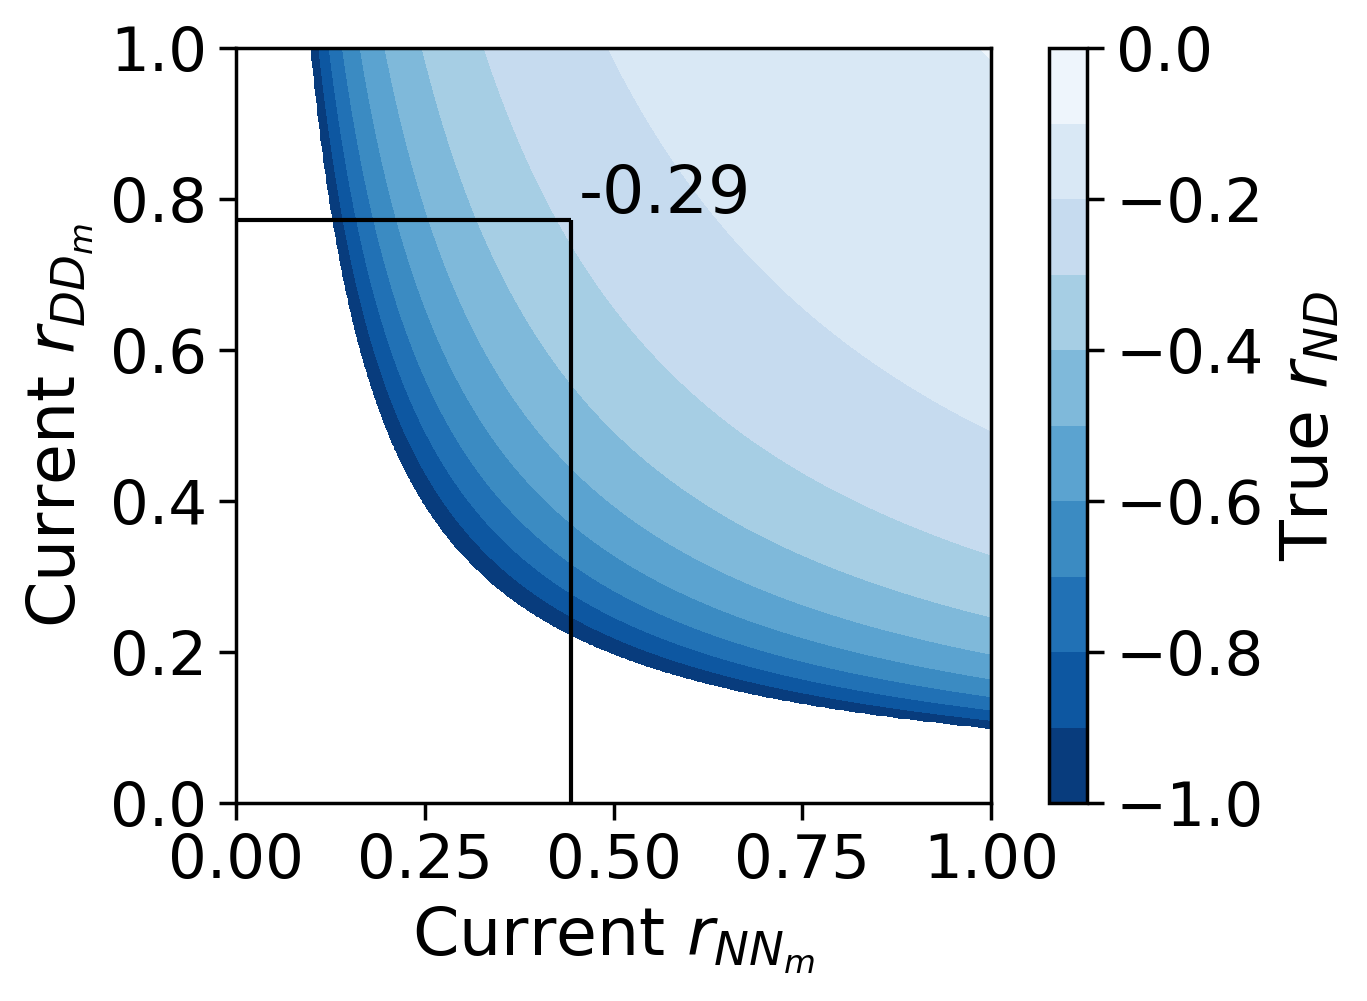

In [25]:
XXms = np.linspace(0.0001, 1, 1000)
YYms = np.linspace(0.0001, 1, 1000)
zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        zz[ii,jj] = XmYm_rbs / (xxm * yym)
        
zz[(zz < -1)] = -10

fig,ax = plt.subplots(1, dpi=250)
contours = ax.contourf(XXms, YYms, zz, vmin=-1, vmax=0, levels=np.arange(-1,0.1, 0.1), cmap='Blues_r')
cbar = fig.colorbar(contours, ticks=np.arange(-1, 0.1, 0.2), label='True $r_{ND}$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
ax.set_xlabel('Current $r_{NN_m}$')
ax.set_ylabel('Current $r_{DD_m}$')
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.vlines(XXm_rbs,0,YYm_rbs)
ax.hlines(YYm_rbs,0,XXm_rbs)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(XXm_rbs +0.01, YYm_rbs + 0.01, f'{true_rbs:0.02f}')
fig.savefig(figure_path/'current_true.png', bbox_inches='tight')

In [26]:
ex_XXm = 0.7
ex_YYm = 0.9

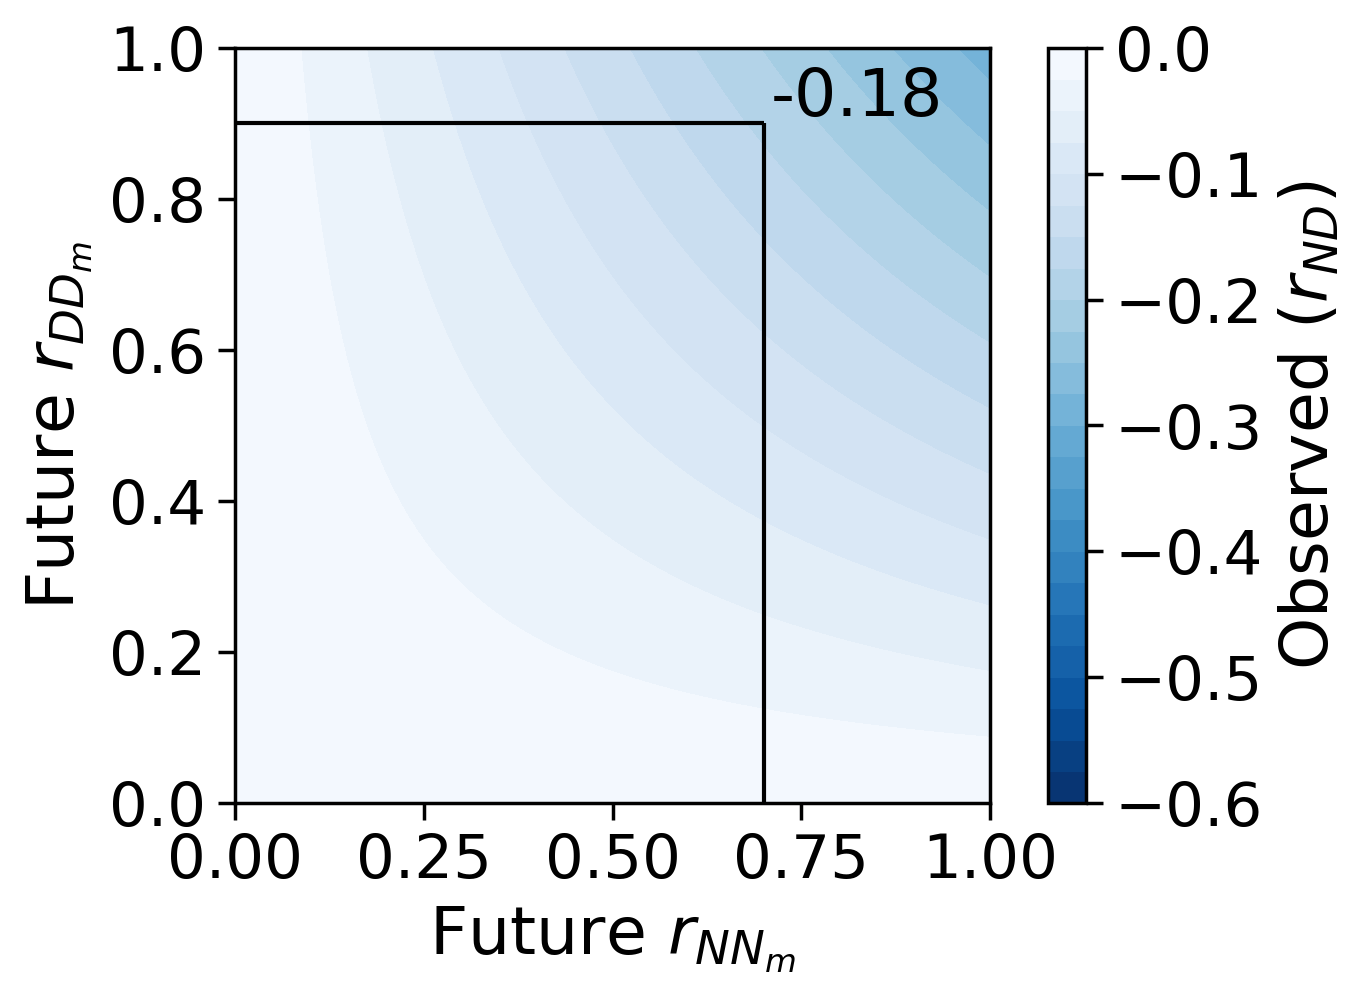

In [27]:
XXms = np.linspace(0.0001, 1, 1000)
YYms = np.linspace(0.0001, 1, 1000)
zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        zz[ii,jj] = true_rbs * (xxm * yym)

fig,ax = plt.subplots(1, dpi=250)
contours = ax.contourf(XXms, YYms, zz, vmin=-0.6, vmax=0, levels=np.arange(-0.6,0.025, 0.025), cmap='Blues_r')
cbar = fig.colorbar(contours, ticks=np.arange(-1, 0.1, 0.1), label='Observed $(r_{ND})$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.set_xlabel('Future $r_{NN_m}$')
ax.set_ylabel('Future $r_{DD_m}$')
ax.vlines(ex_XXm, 0, ex_YYm)
ax.hlines(ex_YYm, 0, ex_XXm)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(ex_XXm +0.01, ex_YYm + 0.01, f'{true_rbs * ex_XXm * ex_YYm:0.02f}')
fig.savefig(figure_path/'future_rnd.png', bbox_inches='tight')

Text(0.71, 0.91, '-0.34')

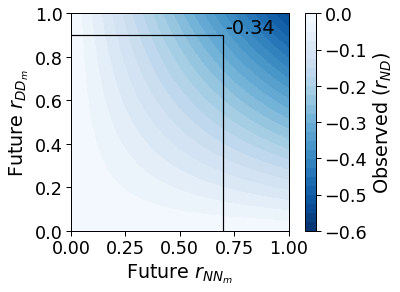

In [28]:
XXms = np.linspace(0.0001, 1, 1000)
YYms = np.linspace(0.0001, 1, 1000)
zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        zz[ii,jj] = lci_rbs * (xxm * yym)

fig,ax = plt.subplots(1)
contours = ax.contourf(XXms, YYms, zz, vmin=-0.6, vmax=0, levels=np.arange(-0.6,0.025, 0.025), cmap='Blues_r')
cbar = fig.colorbar(contours, ticks=np.arange(-1, 0.1, 0.1), label='Observed $(r_{ND})$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.set_xlabel('Future $r_{NN_m}$')
ax.set_ylabel('Future $r_{DD_m}$')
ax.vlines(ex_XXm, 0, ex_YYm)
ax.hlines(ex_YYm, 0, ex_XXm)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(ex_XXm +0.01, ex_YYm + 0.01, f'{lci_rbs * ex_XXm * ex_YYm:0.02f}')

Text(0.71, 0.91, '0.00')

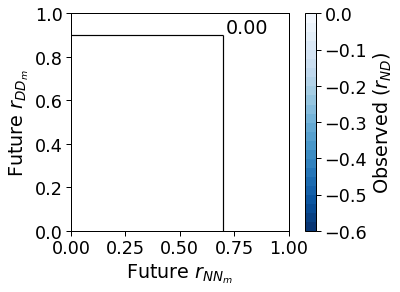

In [29]:
XXms = np.linspace(0.0001, 1, 1000)
YYms = np.linspace(0.0001, 1, 1000)
zz = np.zeros((XXms.shape[0], YYms.shape[0]))
for ii, xxm in enumerate(XXms):
    for jj, yym in enumerate(YYms):
        zz[ii,jj] = uci_rbs * (xxm * yym)

fig,ax = plt.subplots(1)
contours = ax.contourf(XXms, YYms, zz, vmin=-0.6, vmax=0, levels=np.arange(-0.6,0.025, 0.025), cmap='Blues_r')
cbar = fig.colorbar(contours, ticks=np.arange(-1, 0.1, 0.1), label='Observed $(r_{ND})$')
ax.set_xlim((0,1))
ax.set_ylim((0,1))
ax.set_aspect(1)
xmin,xmax = ax.get_xlim()
ymin,ymax = ax.get_ylim()
ax.set_xlabel('Future $r_{NN_m}$')
ax.set_ylabel('Future $r_{DD_m}$')
ax.vlines(ex_XXm, 0, ex_YYm)
ax.hlines(ex_YYm, 0, ex_XXm)
ax.set_xlim((xmin,xmax))
ax.set_ylim((ymin,ymax))
ax.text(ex_XXm +0.01, ex_YYm + 0.01, f'{uci_rbs * ex_XXm * ex_YYm:0.02f}')

In [30]:
uci_rbs * ex_XXm * ex_YYm

0.004254920504253394